## Numerai model upload

<!--

Numerai model uploadを行ってみようと思います。

参考： https://docs.google.com/document/d/1T75KrWbayOUSbLSkgSZEg7VGPrulK8ZkofheENTxABA/edit

---

### 処理の流れ

以下のように比較的シンプルな形としています。

1. データ
     - v4.3のデータを使用
 
2. 前処理
     - 全特徴量だとメモリ不足するため、medium特徴量を利用（およそ700特徴量）
     - 前処理は行わない
 
3. 学習
     - LightGBM
         - ハイパーパラメーターは[Example script](https://github.com/numerai/example-scripts/blob/master/example_model_advanced.py)のものを基本的に利用
         - K-Fold（k=3）で各CVごとにEarly stopping

4. アンサンブル
     - 上記の3-Foldのアンサンブルと、評価に使われていないtarget（jerome_60）を予測した際のモデルでアンサンブル
         - [jerome60はCEOおすすめのtarget](https://zenn.dev/katsu1110/articles/60c777d15e01d5)

5. 後処理
     - 今回使用したmedium特徴量に対して[Feature Neutrization](https://qiita.com/NT1123/items/6c0123e960ab43148eb1)

---

-->

<!--

```py
# 特徴量
from collections import defaultdict
dd = defaultdict(lambda: defaultdict(int))
feature_sets = feature_metadata["feature_sets"]
for feature_set_name1 in feature_sets.keys():
    for feature_set_name2 in feature_sets.keys():
        counter = 0
        feature_set2 = feature_sets[feature_set_name2]
        for feature_name in feature_sets[feature_set_name1]:
            if feature_name in feature_set2:
                counter += 1
        dd[feature_set_name1][feature_set_name2] = counter
df_feature_includes = pd.DataFrame(dd)
df_feature_includes.to_csv("feature_includes.csv")
```

-->

In [1]:
!pip uninstall -y cloudpickle
!pip uninstall -y cloudpickle
!pip install -Uqq numerapi lightgbm==4.0.0 cloudpickle==2.2.1

Found existing installation: cloudpickle 2.2.1
Uninstalling cloudpickle-2.2.1:
  Successfully uninstalled cloudpickle-2.2.1
Found existing installation: cloudpickle 3.0.0
Uninstalling cloudpickle-3.0.0:
  Successfully uninstalled cloudpickle-3.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
distributed 2024.5.1 requires dask==2024.5.1, but you have dask 2024.7.0 which is incompatible.
rapids-dask-dependency 24.6.0a0 requires dask==2024.5.1, but you have dask 2024.7.0 which is incompatible.


In [2]:
import gc
import os
import glob
import json
import pickle
import numerapi
import cloudpickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import scipy.stats as st
import matplotlib.pylab as plt

from tqdm.notebook import tqdm
from contextlib import redirect_stderr
from sklearn.model_selection import KFold

In [3]:
napi = numerapi.NumerAPI()
# Notebook実行時に大量に出力がでてしまうため抑制
with redirect_stderr(open(os.devnull, 'w')):
    napi.download_dataset("v4.3/train_int8.parquet", "train.parquet")
    napi.download_dataset("v4.3/validation_int8.parquet", "valid.parquet")
    napi.download_dataset("v4.3/live_int8.parquet", "live.parquet")
    napi.download_dataset("v4.3/features.json", "features.json")

In [4]:
# 学習周りのconfigファイル
debug = False
seed_all = 0
params = {
    'n_estimators': 5000,
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 32,
    'metric': 'rmse',
    'colsample_bytree': 0.1,
    'subsample': 0.8,
    'seed': seed_all,
    'force_row_wise': True,
    'device': 'gpu'
}

# targetの候補は features.jsonのtargetsの中に記載
# feature_setの候補は feature.jsonのfeature_setsに記載
if debug:
    targets = ["target"]
    feature_set_name = "small"
else:
    targets = ["target"]
    feature_set_name = "medium"

In [5]:
# 特徴量の選択
feature_metadata = json.load(open("features.json"))
for k, v in feature_metadata["feature_sets"].items():
    print(k, len(v))

feature_cols = feature_metadata["feature_sets"][feature_set_name]
print("---")
print(f"feature set: {feature_set_name}, num of features: {len(feature_cols)}")
print("---")

small 42
medium 705
all 2376
v2_equivalent_features 304
v3_equivalent_features 1000
fncv3_features 400
intelligence 35
charisma 290
strength 135
dexterity 51
constitution 335
wisdom 140
agility 145
serenity 95
sunshine 325
rain 666
midnight 244
---
feature set: medium, num of features: 705
---


In [6]:
# データの読み込み
train = pd.read_parquet("train.parquet", columns=feature_cols+["era"]+targets).dropna()
if debug:
    train = train.head(1000)
print(train.shape)

(2420521, 707)


In [7]:
train.groupby("era")["target"].count()

era
0001    2072
0002    2260
0003    2334
0004    2399
0005    2406
        ... 
0570    4804
0571    4811
0572    4793
0573    4793
0574    4801
Name: target, Length: 574, dtype: int64

In [8]:
# 学習
cv = KFold(n_splits=3)
models = []
for target_idx, target in enumerate(targets, start=1):
    for fold, (trn_idx, val_idx) in enumerate(cv.split(train), start=1):
        trn_x = train.iloc[trn_idx, :][feature_cols].values
        trn_y = train.iloc[trn_idx, :][target].values
        val_x = train.iloc[val_idx, :][feature_cols].values
        val_y = train.iloc[val_idx, :][target].values

        print("-----")
        print(f"Target: {target}, fold: {fold}")

        model = lgb.LGBMRegressor(**params)
        model.fit(
            trn_x, trn_y,
            eval_set=[(val_x, val_y)],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)],
        )
        models.append(model)

        model.booster_.save_model(f"model.lgb.fold_{fold}.{target}.seed_{seed_all}.txt")
        pickle.dump(model, open(f"model.lgb.fold_{fold}.{target}.seed_{seed_all}.pkl", 'wb'))
        del trn_x, trn_y, val_x, val_y; gc.collect()


-----
Target: target, fold: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1613680, number of used features: 705
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 705 dense feature groups (547.86 MB) transferred to GPU in 1.032790 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.500004
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3043]	valid_0's rmse: 0.222795
-----
Target: target, fold: 2
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1613681, number of used features: 705
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 705 dense feature groups (547.86 MB) transferred to GPU in 0.949018 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.5

In [9]:
del train; gc.collect()

0

In [10]:
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    def neutralize(df, columns, neutralizers=[], proportion=1.0, normalize=True, era_col="era"):
        unique_eras = df[era_col].unique()
        computed = []
        for u in unique_eras:
            df_era = df[df[era_col] == u]
            scores = df_era[columns].values
            if normalize:
                scores2 = []
                for x in scores.T:
                    x = (st.rankdata(x, method='ordinal') - .5) / len(x)
                    x = st.norm.ppf(x)
                    scores2.append(x)
                scores = np.array(scores2).T
            exposures = df_era[neutralizers].values

            scores -= proportion * exposures.dot(
                np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))
            scores /= scores.std(ddof=0)
            computed.append(scores)
        return pd.DataFrame(np.concatenate(computed),
                            columns=columns,
                            index=df.index)
    
    # main:    
    preds_live = np.zeros(len(live_features))
    for model in models:
        preds_live += model.predict(live_features[feature_cols]) / len(models)
    live_features["prediction"] = preds_live
    
    # Feature Neutralization
    # Ref: https://qiita.com/NT1123/items/6c0123e960ab43148eb1
    live_predictions = neutralize(
        live_features,
        columns=["prediction"], 
        neutralizers=feature_cols, 
        proportion=1.0,
        normalize=True,
        era_col='era'
    ).rank(pct=True, method="first")
    return live_predictions

In [11]:
models = []
for path in glob.glob(f"model.*.txt"):
    models.append(lgb.Booster(model_file=path))

# Live dataでテストを行う
live = pd.read_parquet("live.parquet")
live_sub = predict(live)

In [12]:
# 予測する関数をpredict.pklとして保存（このファイルをNumeraiに提出してください）
p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)

In [13]:
valid = pd.read_parquet("valid.parquet", columns=feature_cols+["era"]+targets).dropna()
valid_sub = predict(valid)

valid_sub["era"] = valid["era"]
valid_sub["target"] = valid["target"]
del valid; gc.collect()

spr_list = []
for era in tqdm(sorted(valid_sub["era"].unique())):
    valid_sub_ext = valid_sub.query("era == @era")
    spr = st.spearmanr(valid_sub_ext["prediction"], valid_sub_ext["target"])[0]
    spr_list.append(spr)

mean = np.mean(spr_list)
sharpe_ratio = np.mean(spr_list) / np.std(spr_list)
print(f"Mean: {round(mean, 4)}, Sharpe: {round(sharpe_ratio, 4)}")

  0%|          | 0/545 [00:00<?, ?it/s]

Mean: 0.0174, Sharpe: 0.9028


Mean: 0.0174, Sharpe: 0.9028


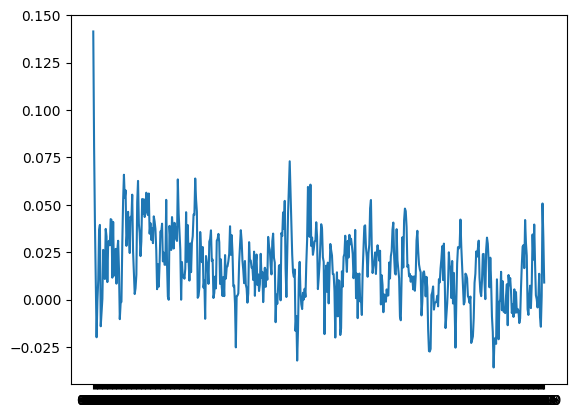

In [14]:
print(f"Mean: {round(mean, 4)}, Sharpe: {round(sharpe_ratio, 4)}")
plt.plot(sorted(valid_sub["era"].unique()), spr_list)

In [15]:
!rm *.parquet